In [80]:
import os
import platform
import random
import time
import sys

import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import seaborn as sns
import tensorflow as tf
from IPython.display import HTML
from PIL import Image

# silence tensorflow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# import vgg19 pretrained model from keras
import tensorflow as tf
from keras import backend as K
from keras import models, layers
from tensorflow import keras

# getting rid of the warning messages about optimizer graph
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(3)

In [56]:
# print Tensorflow and CUDA information
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.experimental.list_physical_devices('CPU')))
print(f"Tensorflow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
 
if tf.test.gpu_device_name():
    gpu_devices = tf.config.list_physical_devices('GPU')
    details = tf.config.experimental.get_device_details(gpu_devices[0])
    name = details.get('device_name', 'Unknown GPU')
    
    print(f"Using {name}")
else:
    print("No GPU found")

Num GPUs Available:  1
Num CPUs Available:  1
Tensorflow version: 2.11.0
Keras version: 2.11.0
Using NVIDIA GeForce RTX 3070 Laptop GPU


2023-04-14 00:58:42.827257: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-14 00:58:42.827353: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-14 00:58:42.827372: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-14 00:58:42.827618: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-14 00:58:42.827627: I tensorflow/core/co

In [87]:
# Seed control, for better reproducibility 
# NOTE: this does not gurantee results are always the same
seed = 22
random.seed(seed)
np.random.seed(seed)

EPOCHS = 500

BATCH_SIZE = 1024 # might try to use large batches (we will discuss why later when we talk about BigGAN)
# NOTE: the batch_size should be an integer divisor of the data set size  or torch
# will give you an error regarding batch sizes of "0" when the data loader tries to
# load in the final batch

# setup GAN dataset
(train_images_raw, train_labels_raw), (_, _) = tf.keras.datasets.cifar10.load_data()

# only use airplane, automobile, ship, and truck images
train_images_raw = train_images_raw[np.where(np.isin(train_labels_raw, [0, 1, 8, 9]))[0]]
train_labels = train_labels_raw[np.where(np.isin(train_labels_raw, [0, 1, 8, 9]))[0]]

train_images = train_images_raw.reshape(train_images_raw.shape[0], 32, 32, 3).astype('float32')
# Normalize the images to [-1, 1]
train_images = (train_images - 127.5) / 127.5

# print the shape of the dataset
print(f"Shape of the dataset: {train_images.shape}")

# print the number of images in each class
print(f"Number of images in each class: {np.unique(train_labels, return_counts=True)[1]}")

# set the buffer size to the size of the dataset
BUFFER_SIZE = train_images.shape[0]

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# cache the dataset to memory to get a speedup while reading from it.
train_dataset = train_dataset.cache()

Shape of the dataset: (20000, 32, 32, 3)
Number of images in each class: [5000 5000 5000 5000]


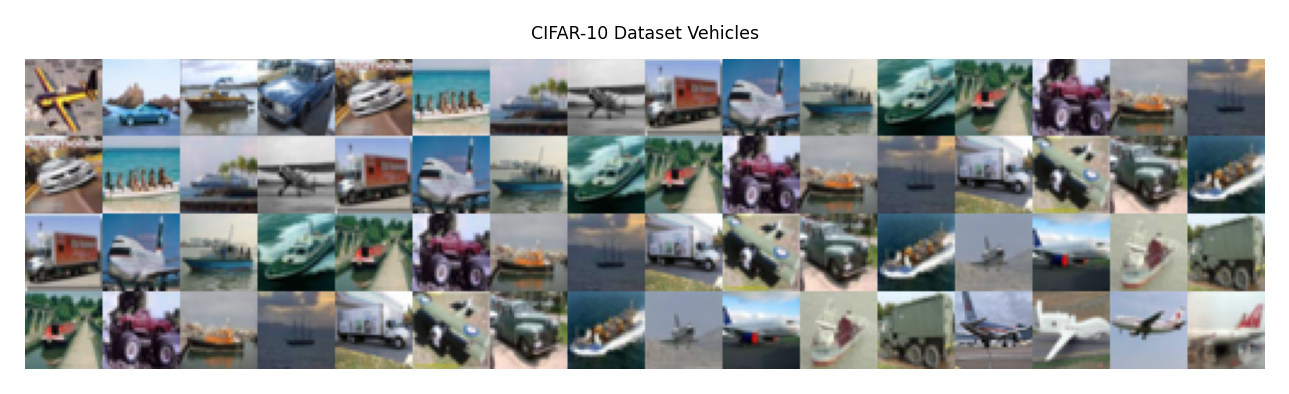

In [88]:
def make_grid(images):
    num_images = 64
    height = 4
    width = 16

    size = images.shape[1]
    grid = np.zeros((height * size, width * size, 3))

    # Get the total number of images in img_batches
    total_images = images.shape[0]

    # Generate 64 random unique indices within the range of total_images
    random_indices = np.random.choice(total_images, num_images, replace=False)

    for i in range(height):
        for j in range(width):
            idx = i * height + j
            random_idx = random_indices[idx]

            im = images[random_idx, :, :, :]
            grid[i * size:(i + 1) * size, j * size:(j + 1) * size, :] = im.reshape((size, size, 3))

    # Normalize the grid values to the range [0, 1] for displaying
    grid = (grid - grid.min()) / (grid.max() - grid.min())

    return grid

def plot_grid(grid, title=None):

    # Create a figure with double the DPI
    plt.figure(dpi=2.5 * plt.rcParams['figure.dpi'])

    if title is not None:
        plt.title(title, fontsize=5)

    plt.imshow(grid)
    plt.axis('off')
    plt.show()

grid = make_grid(train_dataset.take(1).as_numpy_iterator().next())
plot_grid(grid, title="CIFAR-10 Dataset Vehicles")

In [89]:
latent_dim = 100
size = 32
channels = 3


# this model originally from https://www.tensorflow.org/tutorials/generative/dcgan 
# manipulated to have different sizing possible
def make_generator_model():
    # assume we have a 100 dimensional sampling vector
    
    # First, transform the input into a 7x7 256-channels feature map, from latent space
    # latent space starts at 100, then upsamples for convolutio
    model = tf.keras.Sequential()
    int_size_4 = int(size/4)
    model.add(layers.Dense(int_size_4*int_size_4*256, use_bias=False, input_shape=(latent_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # reshape to imaging for convolution
    model.add(layers.Reshape((int_size_4, int_size_4, 256)))
    assert model.output_shape == (None, int_size_4, int_size_4, 256)  # Note: None is the batch size

    # we will use the sequential API
    # in order to create some blocks
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, int_size_4, int_size_4, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    int_size_2 = int(size/2)
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, int_size_2, int_size_2, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(channels, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, size, size, channels)

    return model

In [90]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[size, size, channels]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

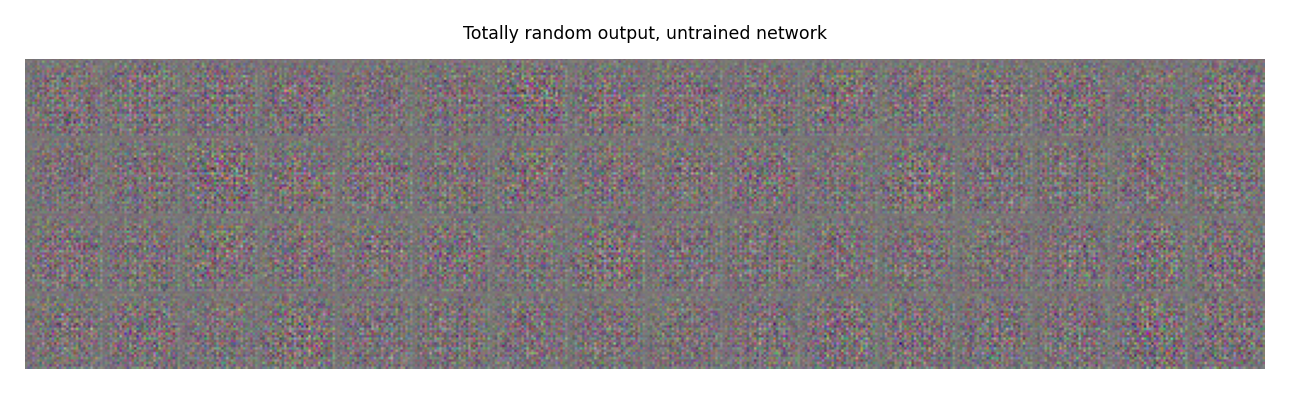

(1024, 1)
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 16384)             1638400   
                                                                 
 batch_normalization_21 (Bat  (None, 16384)            65536     
 chNormalization)                                                
                                                                 
 leaky_re_lu_35 (LeakyReLU)  (None, 16384)             0         
                                                                 
 reshape_7 (Reshape)         (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_21 (Conv2D  (None, 8, 8, 128)        819200    
 Transpose)                                                      
                                                                 
 batch_normalization_22 (Bat  (None, 8, 8, 

In [91]:
generator = make_generator_model()
discriminator = make_discriminator_model()

noise = tf.random.normal([BATCH_SIZE, latent_dim])
generated_image = generator(noise, training=False)

random_grid = make_grid(generated_image.numpy())
plot_grid(random_grid, title='Totally random output, untrained network')

decision = discriminator(generated_image)
print(decision.numpy().shape) # print out 256 decisions

generator.summary()

In [92]:
# Define the output as normal GAN
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True) # binary cross entropy 

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Is AdaM good here? Would that improve performance? :) 
# Decay rate adjustment? 
# set discriminator learning higher than generator?
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# create Utils functions for saving and loading 
checkpoint_dir = 'models/' 
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

EPOCHS = 50
num_examples_to_generate = 64 # 8x8 grid of thr outputs, for testing over time

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
test_latent_dims = tf.random.normal([num_examples_to_generate, latent_dim])

def checkpoint_images(model, test_input, file_prefix):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)
    grid = make_grid(predictions.numpy())
    
    np.save(f'models/{file_prefix}_images.npy',grid)
    
    return grid

In [93]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    # get some random noise for generating images
    noise = tf.random.normal([BATCH_SIZE, latent_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # send through the generator
        generated_images = generator(noise, training=True)

        # save the output from discrimnator for actual batch and generated
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        # get loss for generator to fool discriminator 
        gen_loss = generator_loss(fake_output)
        # get loss for generator to tell the difference
        disc_loss = discriminator_loss(real_output, fake_output)
        
    
    # now update the models with their optimizers
    # only update the correct models with the specified gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        
img_list = []
for epoch in range(EPOCHS):
    start = time.time()

    for image_batch in train_dataset:
        train_step(image_batch)


    # Save the model every 15 epochs
    if (epoch + 1) % 5 == 0:
        checkpoint.save(file_prefix = checkpoint_dir+'vanilla_tf')
        # Produce images for animation
        tmp = checkpoint_images(generator,
                                 test_latent_dims,
                                'vanilla_tf')
        img_list.append(tmp)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

Time for epoch 1 is 4.875754356384277 sec
Time for epoch 2 is 2.1118595600128174 sec
Time for epoch 3 is 2.191822052001953 sec
Time for epoch 4 is 2.2047159671783447 sec
Time for epoch 5 is 2.42516827583313 sec
Time for epoch 6 is 2.133090019226074 sec
Time for epoch 7 is 2.2126028537750244 sec
Time for epoch 8 is 2.2049965858459473 sec
Time for epoch 9 is 2.2127816677093506 sec
Time for epoch 10 is 2.45538592338562 sec
Time for epoch 11 is 2.170649528503418 sec
